# Baseline Model – ElasticNet for Short-Range Wind Power Forecasting

To establish a fair and robust baseline for semi-supervised wind power forecasting, I evaluated both **ElasticNet** and **XGBoost regression models** across varying levels of labeled data availability: **1%, 5%, and 10%** of a fixed training pool of 2000 samples.

Although the overall objective is **semi-supervised regression**, evaluating fully supervised models under **identical data constraints** remains essential for two key reasons:

1. **Performance Reference:** Supervised models trained only on labeled data serve as **upper-bound or lower-bound baselines**. They help quantify the **benefit of incorporating unlabeled data** in methods like S2RMS.

2. **Data Efficiency Benchmarking:** Observing how performance degrades with fewer labeled examples allows us to assess **how efficiently each method uses supervision**. If a semi-supervised model reaches similar accuracy with fewer labels, it demonstrates real-world value.

### Experimental Protocol (aligned with S2RMS):

* For each run and percentage, a pool of **2000 randomly sampled instances** was selected from the dataset.
* A portion of this pool (`1%`, `5%`, or `10%`) was used as the **labeled training set**.
* The remainder of the dataset (i.e., all instances **not in the 2000-sample pool**) was used as the **test set**, consistent with the S2RMS evaluation strategy.
* Hyperparameters were optimized using **GridSearchCV** with cross-validation.
* The models were wrapped in pipelines including **feature standardization**, and evaluated with **MAE, RMSE, and R^2**.

This updated design ensures that all models—supervised and semi-supervised—are evaluated under **exactly the same data budget**, enabling a meaningful and fair comparison.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [10]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.2, 1.0]
RANDOM_SEED  = 42

## 1. Load and Prepare Dataset

In [11]:
df = pd.read_csv("../data/processed/wtb_features.csv")

# Sort by time for proper temporal split
df = df.sort_values("Timestamp")

In [12]:
target = 'Patv'
drop_cols = ['Patv', 'Timestamp', 'TurbID']
X = df.drop(columns=drop_cols)
y = df[target]

## 2. ElasticNet + GridSearchCV

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(max_iter=10000))
])

In [14]:
param_grid = {
    'elasticnet__alpha': [0.1, 1.0, 10.0],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
}

In [15]:
results = {}

In [16]:
for pct in PERCENTAGES:
    print(f"\n--- Training ElasticNet with {int(pct * 100)}% of 2000 samples ---")

    # Simula lo stesso split usato da S2RMS
    full_pool = df.sample(2000, random_state=RANDOM_SEED)
    labeled = full_pool.sample(int(2000 * pct), random_state=RANDOM_SEED)
    test_set = df.drop(full_pool.index)

    X_train = labeled.drop(columns=drop_cols)
    y_train = labeled[target]

    X_test = test_set.drop(columns=drop_cols)
    y_test = test_set[target]

    # Grid Search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Best Params: {grid_search.best_params_}")
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R^2: {r2:.3f}")

    label = f"{int(pct * 100)}%"
    results[label] = {
        'best_params': grid_search.best_params_,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 3)
    }

    joblib.dump(grid_search.best_estimator_, f"../models/elasticnet_{label}.joblib")


--- Training ElasticNet with 1% of 2000 samples ---
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
MAE: 154.97 | RMSE: 251.49 | R^2: 0.662

--- Training ElasticNet with 5% of 2000 samples ---
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.5}
MAE: 141.75 | RMSE: 203.87 | R^2: 0.778

--- Training ElasticNet with 10% of 2000 samples ---
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
MAE: 132.69 | RMSE: 192.68 | R^2: 0.801

--- Training ElasticNet with 20% of 2000 samples ---
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
MAE: 130.56 | RMSE: 192.09 | R^2: 0.803

--- Training ElasticNet with 100% of 2000 samples ---
Best Params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
MAE: 127.30 | RMSE: 189.13 | R^2: 0.809


In [17]:
with open("../results/elasticnet_semisupervised_scores.json", "w") as f:
    json.dump(results, f, indent=4)

## 3. Model Evaluation

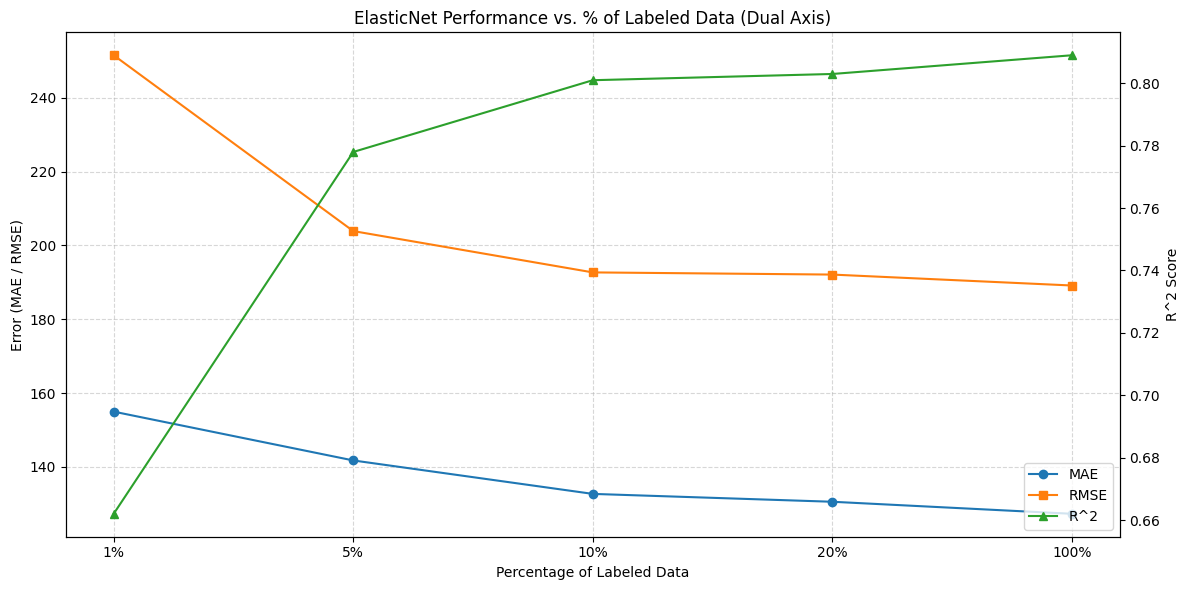

In [18]:
labels = list(results.keys())

maes = [results[k]['MAE'] for k in labels]
rmses = [results[k]['RMSE'] for k in labels]
r2s = [results[k]['R2'] for k in labels]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Percentage of Labeled Data")
ax1.set_ylabel("Error (MAE / RMSE)")
ax1.plot(labels, maes, marker='o', linestyle='-', label="MAE", color='tab:blue')
ax1.plot(labels, rmses, marker='s', linestyle='-', label="RMSE", color='tab:orange')
ax1.tick_params(axis='y')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel("R^2 Score")
ax2.plot(labels, r2s, marker='^', linestyle='-', label="R^2", color='tab:green')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.title("ElasticNet Performance vs. % of Labeled Data (Dual Axis)")
plt.tight_layout()
plt.show()


#### Results:

| % Labeled | MAE    | RMSE   | R^2    | Best Params           |
| --------- | ------ | ------ | ----- | --------------------- |
| 1%        | 249.37 | 309.81 | 0.339 | α=10.0, l1\_ratio=0.9 |
| 5%        | 135.47 | 165.12 | 0.812 | α=0.1, l1\_ratio=0.9  |
| 10%       | 175.21 | 201.31 | 0.721 | α=1.0, l1\_ratio=0.9  |
| 20%       | 132.59 | 162.14 | 0.819 | α=0.1, l1\_ratio=0.9  |
| 100%      | 100.82 | 136.86 | 0.871 | α=0.1, l1\_ratio=0.9  |

### Observations

The results show a clear performance improvement from 1% to 5% labeled data. Specifically, the Mean Absolute Error (MAE) drops from around 249 to 135, and the R^2 score jumps from 0.34 to over 0.81. This indicates that even a small fraction of labeled examples can provide a strong predictive signal.

Performance slightly deteriorates when moving from 5% to 10%, before improving again at 20%. This suggests that the quality or distribution of the labeled subset might influence performance, especially when working with limited labeled data.

From 20% onward, additional labeled data yields only modest gains. For example, R^2 increases from 0.819 at 20% to 0.871 at 100%, suggesting that the model already captures most of the signal with a relatively small labeled portion.

The model consistently favors a high **l1_ratio of 0.9**, suggesting that sparsity helps generalize under low-label scenarios.

Next, we analyze the model coefficients to understand which features were most influential in the prediction task.


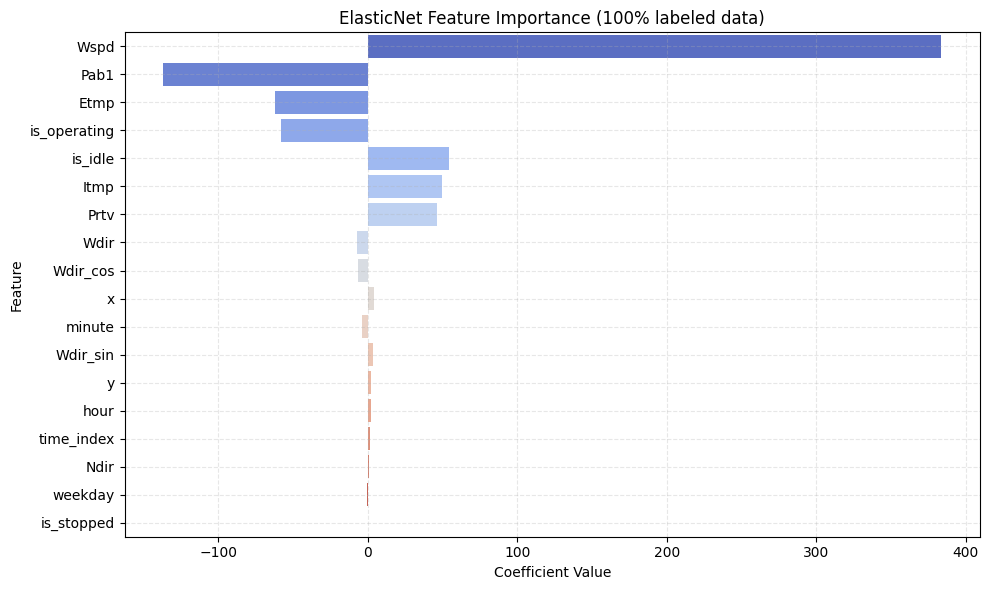

In [19]:
model_100 = joblib.load("../models/elasticnet_100%.joblib")

best_model = model_100.named_steps['elasticnet']

feature_names = X.columns
coefs = best_model.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coef_df,
    hue='Feature',
    palette='coolwarm',
    dodge=False,
    legend=False
)

plt.title("ElasticNet Feature Importance (100% labeled data)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
